# Clase 05b: Análisis vectorial y Geoprocesos

Luego de haber probado con distintos filtros espaciales de nuestras casificaciones y haberlas vectorizado, pasaremos a aprender algunos geoprocesos que nos permitirán obtener información nueva.

Abordaremos aquí un caso de aplicación: A partir de nuestras clasificaciones vectorizadas, haremos operaciones para conocer el área construida por radio censal. La idea será llegar a algo parecido a lo siguiente:

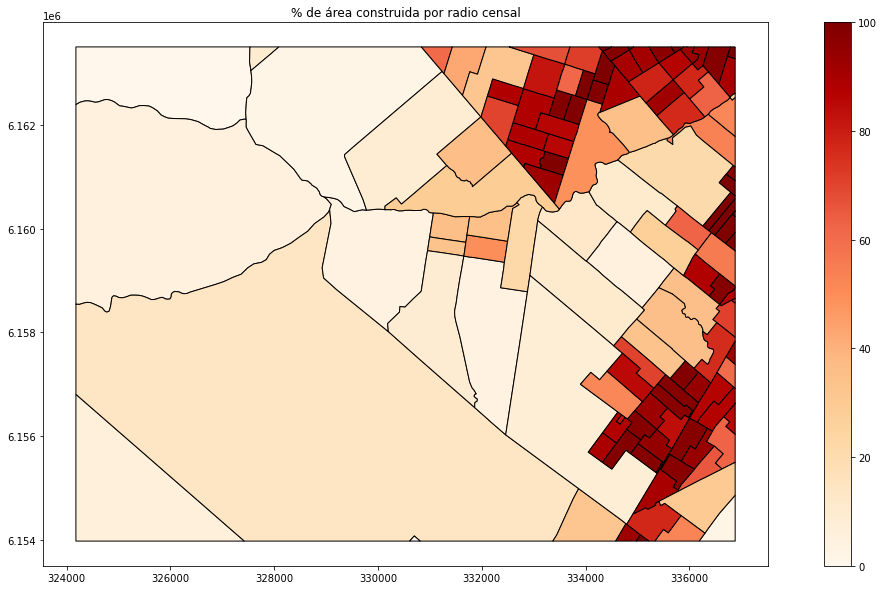

Contamos con la base cartográfica del Censo Nacional de Población y Vivienda de 2010, que incluye tanto polígonos de fracciones como radios censales para cada provincia del país, y aprovecharemos la capa de clasificación poligonizada que trabajamo en la Notebook anterior.

## 1. Conocer la cantidad de área construida por radio censal

### 1.1. Intersección

Ahora que tenemos la clasificación en formato vectorial, estamos habilitados a realizar otras operaciones. Como vimos en la Clase 04, al leer un vector como GeoDataFrame podemos, entre otras cosas, calcular el área de cada elemento. El problema es que a nosotros nos interesa saber el área construida por Radio Censal, con lo cual estamos ante un problema de agregación espacial: Tenemos que "pasarle" de alguna manera la información del radio al que pertenece a cada uno de los polígonos de la clasificación. 

En un ambiente SIG, esto suele resolverse con lo que se conoce como **geoprocesos**, que son operaciones donde se genera nueva información a partir de la relación espacial o geométrica entre varios vectores. Uno de los más usados es la **intersección** , donde se combinan las geometrías de dos capas vectoriales dando lugar a una nueva:

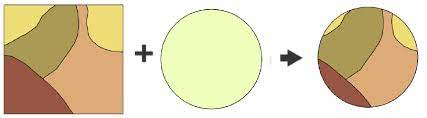

La particularidad que tiene este geoproceso es que además de combinarse las geometrías, también se combinan los atributos o columnas. Veamos como se hace con GeoPandas:

```python
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd
from matplotlib import pyplot as plt
import sys
sys.path.append('../')
import funciones as fn

clasif_vector = gpd.read_file('../data/proc/clasif_mode.shp')
radios = gpd.read_file('../data/raw_data/vector/radios_BA.shp')

#Consultamos el SRC de las capas:
print(radios.crs, clasif_vector.crs)

#Reproyectamos los radios al SRC de la clasificación:
radios = radios.to_crs(32721)
```

In [1]:
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd
from matplotlib import pyplot as plt
import sys
sys.path.append('../')
import funciones as fn

clasif_vector = gpd.read_file('../data/proc/clasif_mode.shp')
radios = gpd.read_file('../data/raw_data/vector/radios_BA.shp')

#Consultamos el SRC de las capas:
print(radios.crs, clasif_vector.crs)

#Reproyectamos los radios al SRC de la clasificación:
radios = radios.to_crs(32721)

EPSG:22183 EPSG:32721


Como son vectores con distinta extensión espacial, debemos definir los límites del ploteo: Nos interesa tomar las coordenadas de nuestra clasificación solamente:

```python
minx, miny, maxx, maxy = clasif_vector.total_bounds

#Los visualizamos en conjunto:

ax = clasif_vector.plot(figsize=(10,10), color = 'red',edgecolor = 'blue', zorder =1)
radios.boundary.plot(ax=ax, edgecolor='black', zorder =2)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
plt.show()
```

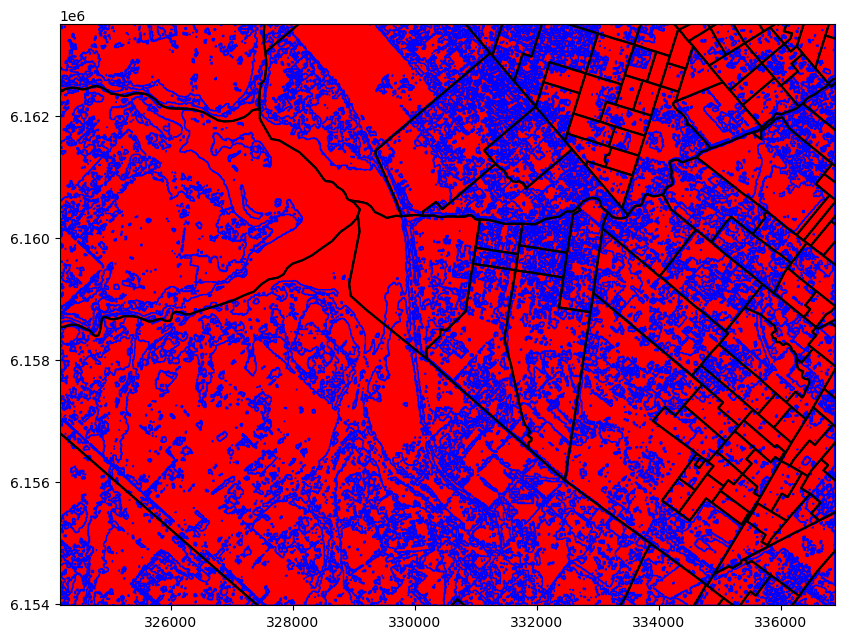

In [2]:
minx, miny, maxx, maxy = clasif_vector.total_bounds

#Los visualizamos en conjunto:

ax = clasif_vector.plot(figsize=(10,10), color = 'red',edgecolor = 'blue', zorder =1)
radios.boundary.plot(ax=ax, edgecolor='black', zorder =2)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
plt.show()

La capa de radios censales ocupa toda la extensión de la Provincia de Buenos Aires. Sin embargo, luego de hacer la intersección la salida quedará reducida a la extensión de la clasificación.

Geopandas permite realizar sus geoprocesos por medio del método **Overlay**, que se refiere a superposición. Además de la intersección, se puede unir geometrías, obtener la diferencia entre las mismas, o su diferencia simétrica. Se puede consultar con más detalle en la [documentación](https://geopandas.org/docs/user_guide/set_operations.html) de Geopandas.

```python
#Hacemos la intersección

interseccion = gpd.overlay(clasif_vector,radios, how ='intersection')
interseccion.head(5)
```

Ploteamos esta nueva capa coloreando los elementos por el código original del radio, para ver qué aspecto tiene:

```python
interseccion.plot(column = 'link',figsize = (10,10), edgecolor = 'black')
plt.show()
```

Como se puede ver, ahora hemos combinado las geometrías de ambas capas, y en la tabla vemos tanto la columna DN (heredada de la clasificación), como los campos que venían con la tabla de radios. Podemos ahora calcular el área de aquellos polígonos pertenecientes a la clase 4 (Construcciones / Urbano). Recordemos las clases de nuestra clasificación:

- Agua: Píxeles con valor 0
- Bosque: Píxeles con valor 1
- Humedal: Píxeles con valor 2
- Rural: Píxeles con valor 3
- Urbano: Píxeles con valor 4


```python
interseccion.loc[interseccion.DN == 4, 'area_construido_m2'] = interseccion.loc[interseccion.DN == 4].area
```

Si nos fijamos de nuevo en la tabla, solo se ha calculado el área para la clase 4:

```python
#Nos traemos los primeros 5, luego de ordenar de manera descendente por area_construido_m2
interseccion.sort_values('area_construido_m2', ascending=False).head(5)
```

Sin embargo no tenemos aún agregados los datos por radio censal, tenemos nuestros polígonos partidos por los límites de las dos capas originales. 

Lo que podemos hacer ahora es una operación de agregación espacial que se conoce como **Disolver**. Con el Disolver lo que hacemos es agrupar las geometrías en base a una o más columnas, y se genera una nueva capa. Sobre el resto de los datos se puede aplicar algún criterio de agregación o sumarización: Por ejemplo, obtener la media, la suma, la moda, etc:

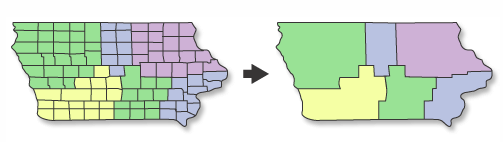

Con GeoPandas hacemos esto con el método **dissolve** (consulta más información sobre este comando [aquí](https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html)):

```python
dissolve = interseccion.dissolve(by = 'link', aggfunc = 'sum', as_index = False)

dissolve.plot(column = 'link',figsize = (10,10), edgecolor = 'black',cmap = 'tab20c')
plt.show()

dissolve.head(5)
```

Ahora si! tenemos otra vez las geometrías de los radios originales, pero como usamos la función de agregación **sum** también sumarizamos la cantidad de metros cuadrados construidos, con lo cual para calcular el porcentaje solo debemos hacer un cálculo simple como lo aprendido en la Clase 4:

```python
# Opción para ver todas las columnas del dataset en el notebook
import pandas as pd
pd.set_option('display.max_columns', 50)

dissolve['porcen_construido'] = (dissolve['area_construido_m2']/dissolve.area)*100
dissolve.head(3)
```

Ploteamos los radios en función del porcentaje calculado:

```python

dissolve.plot(column = 'porcen_construido',
                                         figsize = (20,10),
                                         edgecolor = 'black',
                                         cmap = 'OrRd',
                                        legend = True)
plt.title('% de área construida por radio censal')
```

Para terminar de pulir un poco el resultado, deberíamos descartar todas las columnas que no se refieran al identificador del radio censal ('link') ni a la cantidad de m2 construidos ('area_construido_m2' y 'porcen_construido'), ya que sobre las mismas al hacer el dissolve se aplicó la función de suma cuando en realidad eran datos repetidos.

```python
dissolve = dissolve.drop(columns = ['DN', 'toponimo_i', 'varon', 'mujer', 'totalpobl',
       'hogares', 'viviendasp', 'viv_part_h'])
```

Guardamos nuestro resultado como archivo:

```python
dissolve.to_file('../data/proc/clase05_dissolve.gpkg')
```

### Ejercicio 1.1 (Opcional):

a) Realizar el procedimiento mostrado en el ejemplo de esta notebook, pero para calcular el porcentaje de cada radio censal que está cubierto por bosque, no por construcciones.

b) Programar una función que tomando una clasificación vectorial de entrada, un código de clase de dicha clasificación y una capa vectorial de polígonos, devuelva un Geodataframe donde esté calculado el porcentaje de área que esa clase ocupa en cada polígono del vector. 

### 1.2. Join o Unión Espacial

La unión espacial o _Spatial Join_ en inglés es otra de las operaciones de superposición más usadas en el análisis vectorial. Funciona de manera similar al Merge que aprendimos en la clase 04, en el sentido de que se unen atributos de dos tablas distintas, pero en este caso la unión se realiza en base a la localización en común.

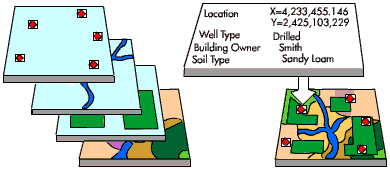

Se suele definir un criterio para "pasar" atributos de una capa a la otra: Por ejemplo si los elementos se intersectan entre sí, o si uno contiene al otro, o si el centro geométrico de un elemento se encuentra comprendido dentro del otro, etc. Geopandas en particular trabaja con distintos tipos de posibles relaciones o predicados geométricos. Se los puede consultar usando `GeoDataFrame.sindex.valid_query_predicates`:

```python
radios.sindex.valid_query_predicates
```



Si quisiéramos por ejemplo pasarle a nuestra capa original de radios, los datos nuevos que calculamos con los m2 construidos, podríamos hacer un _merge_ a nivel de tablas como aprendimos en la Clase 4, o bien podríamos usar el Join espacial que estamos presentando ahora: 

```python
from geopandas.tools import sjoin

radios_sjoin = sjoin(dissolve,radios, how = 'inner', predicate = 'intersects')
```

En el comando **sjoin** tenemos dos parámetros importantes para configurar, que son **how** y **predicate**. El primero nos indica cómo queremos hacer el join ('left', 'inner' o right), y funciona exactamente igual que en el **merge** de Pandas. El segundo se refiere a qué predicado geométrico usar: En este caso pusimos 'intersects' lo cual indica que el join se realizará cuando tengamos dos geometrías que se intersectan.

A primera vista, esto parece funcionar correctamente:

```python
radios_sjoin.head(3)
radios_sjoin.plot(edgecolor = 'black')
```

Sin embargo, hay un problema. Si consultamos la cantidad de elementos de esta nueva capa, y la cantidad de elementos de la capa **dissolve** , estos no son iguales:

```python
print(len(dissolve))
print(len(radios_sjoin))
```

El problema es por el predicado geométrico que estamos usando: al tratarse de una intersección, se generará un elemento nuevo por cada geometría coincida espacialmente con otra, incluso si solo comparten sus bordes. Llevemos la capa a QGIS para ver este problema más claramente:

```python
dissolve.to_file('../data/proc/dissolve.shp')
radios_sjoin.to_file('../data/proc/radios_sjoin.shp')
```

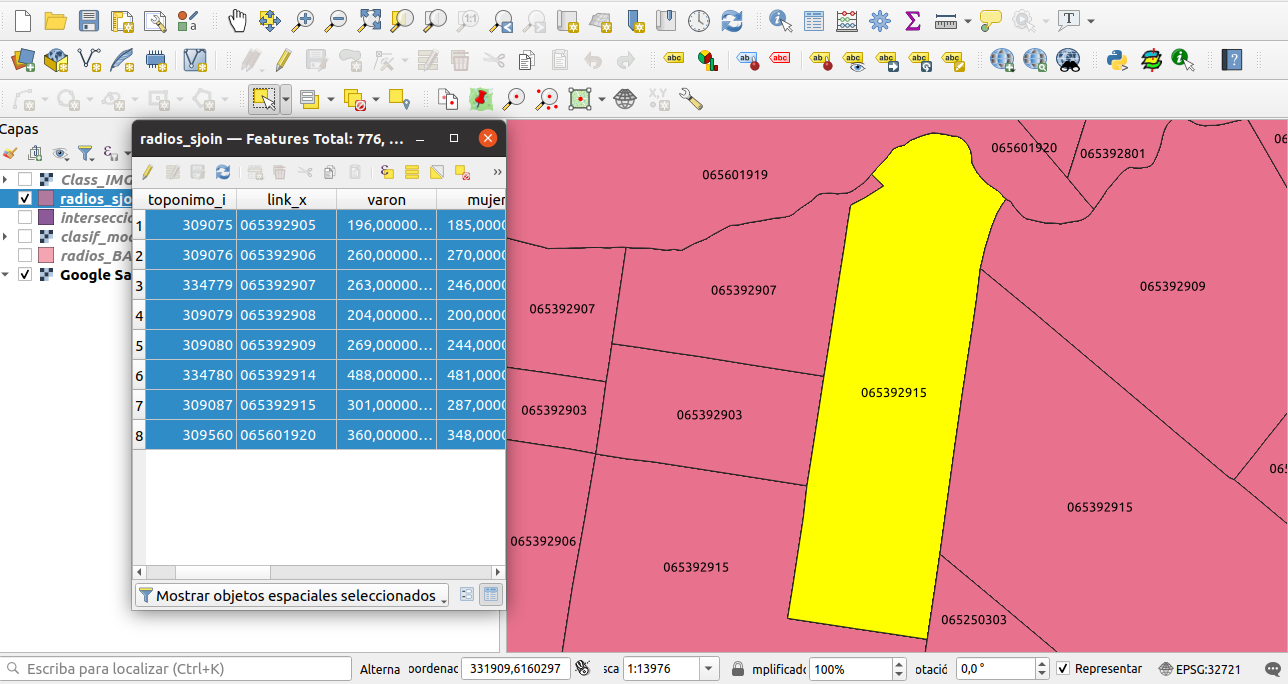

Claramente esto no es lo que buscamos: Seleccionamos una geometría en QGIS y resulta que se mezcló con los elementos vecinos,  y también con los vecinos de sus vecinos!

Ese tipo de problemas no aparecería si el join espacial se hiciera entre puntos y polígonos. Lo que podemos hacer es convertir el GeoDataframe **interseccion_clasif_radios_dissolve** a una capa de puntos, y luego probar el join espacial contra **radios** (polígono).

Así como con el método **boundary** obtenemos los límites o bordes de un polígono, con el método **centroid** podemos generar el centroide del mismo. En SIG el centroide representa el punto central o medio de una geometría:

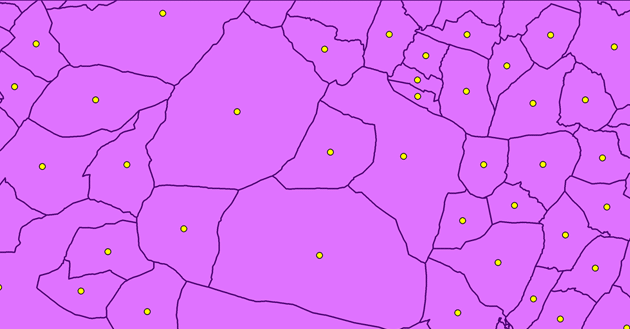



```python
centroides = dissolve.copy()

#Pasamos la geometría a punto usando Centroid
centroides.geometry=centroides.geometry.centroid

#Corroboramos que tenga todos los datos:
centroides.head()
```

```python
from matplotlib import pyplot as plt
ax = dissolve.plot(figsize=(10,10), color = 'red',edgecolor = 'blue', zorder =1)
centroides.plot(ax=ax, color = 'yellow',  zorder =2)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
plt.show()
```

Hacemos de nuevo el Join Espacial con el predicado "contains":
Atención al orden en que pusimos esta vez a las capas!

```python
radios_sjoin = sjoin(radios,centroides, how = 'inner', predicate = 'contains')
radios_sjoin.head(3)

print(len(dissolve))
print(len(radios_sjoin))

radios_sjoin.head(3)
```

¡Ahora sí! Las dos capas tienen la misma cantidad de elementos. No parece haberse generado ninguna repetición. Para corroborarlo, guardamos la capa y la abrimos en QGIS:

```python
radios_sjoin.to_file('../data/proc/radios_sjoin_2.shp')
```

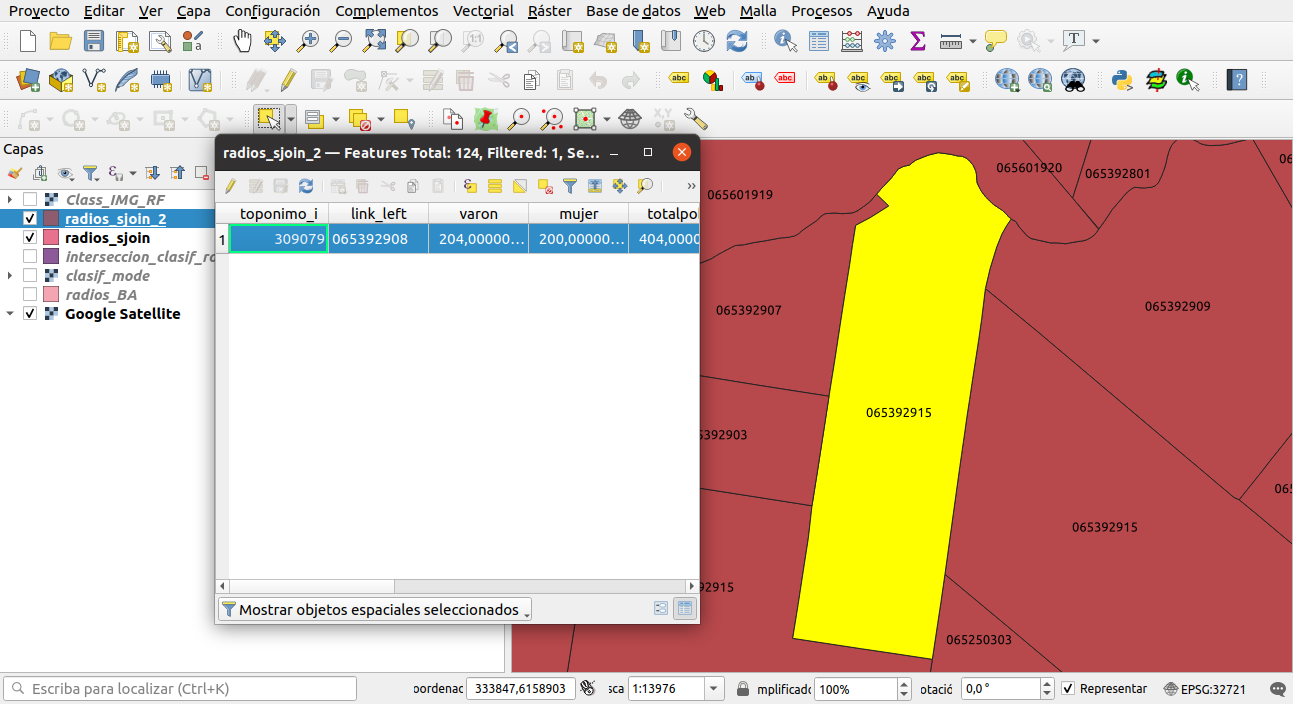

### Ejercicio 1.2:

Utilizar la información contenida en el campo 'link' de la capa de radios para generar a partir de su agregación espacial una capa de fracciones censales (tip: vas a tener que manipular la cadena de texto con los métodos aprendidos en la Clase 01, y luego usar el geoproceso Dissolve). Recordar cómo está organizada la información en esta columna: Los primeros 2 caracteres se refieren al código de provincia, los siguientes 3 al código de partido o departamento, los siguientes 2 al código de fracción, y los últimos 2 al código de radio.

### Ejercicio 1.3:

b) Usar un join espacial para pasarle a la capa puntual de establecimientos educativos (**../data/raw_data/vector/establecimientos_educativos.gpkg**) el dato de la fracción censal a la que pertenecen. Tener en cuenta que las capas pueden estar en un Sistema de Referncia distinto, y habrá que reproyectarlas previamente.